 -----------------------------------------------------------
# Replication of Cogley and Sargent (2005) in `pymc`

* **Author:** Balint Szoke
* **Last update:** June, 2016

> By using the **same data and priors** as that of Cogley and Sargent (2005) this notebook "replicates" the posterior sample of the paper (modulo randomness) with the MCMC sampler of `pymc` 

>> It requires `cogleysargent.py` which contains the following step methods:
 - `ForwardBackward`: $\hspace{6mm}\theta^T \hspace{2mm}\mid\hspace{2mm}Y^{T}, Q, R^{T}$
 - `W_Q`: $\hspace{30mm}Q^{-1}\hspace{2mm}\mid\hspace{2mm} Y^{T}, \theta^{T}$
 - `Metropolis_LH`: $\hspace{9mm} H^T \hspace{2mm}\mid\hspace{2mm}Y^{T},\theta^{T},\beta,\sigma$
 - `N_Beta`: $\hspace{28mm}\beta \hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T, H^T$
 - `IG_Sigma`: $\hspace{22mm}\sigma^2 \hspace{2mm}\mid\hspace{2mm} Y^T, H^T$

>> and `cogleysargent_utils.py` 
 - `Genearate_prior` : class to estimate a SUR model on the training set in order to provide informative priors
 - `cs_model` : a function that creates a pymc model (basically collects the pieces explained below)
 
 -----------------------------------------------------------


In [1]:
%matplotlib inline

# Standard packages:
import numpy as np
import scipy as sp
import scipy.io as sio
from scipy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb

# pymc and application specific packages
import pymc as pm
from cogleysargent import *
from cogleysargent_utils import *

### Model

We consider the following state-space model:

\begin{align}
y_t &= X_t\theta_t + \varepsilon_t \hspace{2cm}\text{where}\hspace{5mm} \varepsilon_t \sim \mathcal{N}(0,R_t) \\
\theta_{t} &= \theta_{t-1} + v_t \hspace{22mm}\text{where}\hspace{5mm} v_t \sim \mathcal{N}(0,Q) \\
\log(h_t) & = \log(h_{t-1}) + \eta_t \hspace{12mm}\text{where}\hspace{5mm} \eta_t \sim \mathcal{N}(0,\text{diag}(\sigma))
\end{align}

where $y_t$ is a vector of endogenous variables, $X_t$ includes constant plus lags of $y_t$ and $\theta_t$ is a vector of VAR parameters. The first equation is the measurement equation; the second is the state equation modeling the VAR coefficients as driftless random walks subject to reflecting barriers. The reflecting barrier is encoded in an indicator function $I(\theta^T)=\prod_{t=1}^T I(\theta_t)$, where $I(\theta_t)$ takes the value $1$ when $\theta_t$ implies roots of the associated VAR polynomial outside the unit circle and $0$ otherwise. This restriction truncates and renormalizes the random walk prior. 

$h_t$ is a vector of independent stochastic volatilities (same size as $y_t$) and 

\begin{align}
R_t = B^{-1}\text{diag}(h_t)(B^{-1})^T
\end{align}

**Notations:**
- $y_t$ and $\varepsilon_t$ are $K\times 1$-vectors for all $t=1,\dots,T$
- $x_t$ contains a constant plus $L$ lags of the endogenous variables, i.e. $x_t = [1, y_{t-1}^T, y_{t-2}^T, \dots, y_{t-L}^T]^T$ is an $M\times 1$ vector, where $M \equiv 1+LK$ and $X_t = I_K \otimes x^T_t$ is a $K\times KM$ matrix 
- $\theta_t$ and $v_t$ are $KM\times 1$ vectors
- $h_t$, $\eta_t$ and $\sigma$ are $K\times 1$-vectors, where $\sigma = [\sigma_1,\dots,\sigma_K]^T$
- $B$ is a $K\times K$ matrix 

$$B = \left[\begin{matrix} 1 & 0 & \dots & 0 \\ \beta_{2,1} & 1 & \dots & 0 \\  \dots & \dots & \dots & \dots \\ \beta_{K,1} & \beta_{K,2} & \dots & 1\end{matrix}\right] $$
- $J=\frac{K(K-1)}{2}$ is the total number of $\beta_{ij}$ included in $B$, i.e. $\beta=[\beta_{21}, \dots,\beta_{K(K-1)}]^T$ is a $J\times 1$ vector


### Priors

We assume that initial state $\theta_0$ and the hyperparameters are independent across blocks

$$f(\theta_0, h_0, Q^{-1}, \beta, \sigma) = f(\theta_0) f(h_0) f(Q^{-1}) f(\beta) f(\sigma) $$

and our priors are

- $\theta_0 \propto I(\theta_0)\mathcal{N}(\bar{\theta},\bar{P})$
- $Q^{-1} \sim \mathcal{W}(KM+1, \bar{Q})$ 
- $\sigma_i \sim \mathcal{IG}(\alpha_{i0},\beta_{i0})$ for $i=1,\dots, K$
- $h_{0,i} \sim \log\mathcal{N}(\bar{h}_i,\bar{P}_{h,i})$ for $i=1,\dots,K$
- $\beta \sim \mathcal{N}(\bar{\beta}, \bar{P}_{\beta})$

Notice that these along with the state equations already provide us with priors for $\theta^T$ and $h^T$.


-------------------------------------------------------_

### Load the sample contained in the .mat file and create a data matrix that we can pass to the prior generator 

   *Sample period:* from 1948:Q2 to 2000:Q4
   
   *Variables:*
   - **dp** : CPI for all urban consumers (seasonally adj), log diff between the third month of each quarter
   - **y3** : yield on 3-month Treasury Bill, average of daily rates in the first month of each quarter
   - **ur** : civilian unemployment rate (seasonally adj), quarterly average of monthly rates
       =>  **ur2** : logit of unemployment

In [2]:
data = sio.loadmat('../data/NEWQDATA.MAT')

var_names = [key_name for key_name in data.keys() if key_name[0] != '_']
d = {}
for i in var_names:
    d[i] = data[i].squeeze()
data_original = pd.DataFrame(data = d, index = pd.date_range('1948-04-01', '2000-12-31', freq = 'Q'))


# Dependent variables of the VAR
y3 = np.expand_dims(data_original['y3'], 1)    # yield on 3-month Treasury bills
dp = np.expand_dims(data_original['dp'], 1)    # CPI for all urban consumers (seasonally-adj)
ur = np.expand_dims(data_original['ur'], 1)    # civilian unemployment rate (seasonally-adj)
ur2 = .01 * np.log(ur / (1 - ur))              # logit of unemployment

y = np.hstack((y3, ur2, dp))

### Defining the model in `pymc`

`Generate_prior` helps us to come up with values for the hyperparameters that define a pymc model (along with the assumed distributional forms):

$$\bar{\theta},\bar{P},\bar{Q},\bar{\beta},\bar{P}_{\beta},\{\alpha_{i0}\}_{i},\{\beta_{i0}\}_{i},\{\bar{h}_i\}_{i},\{\bar{P}_{h,i}\}_{i}$$

Given these parameters and the data we should be able to draw from the posterior distribution of the probabilistic model described above. 

------------------------------------------------------------

Estimate the SUR model on the training sample to get informative priors (and set the remaining hyperparameters so that the prior is relatively "uninformative"...see the paper for further details) 

In [3]:
training = Generate_prior(y)

This class conveniently creates all the necessary pieces for the pymc model

In [4]:
X, Y_obs, X_obs = training.create_YX()[3:]
theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, Ph_bar, P_bar, Q_bar = training.informative_prior()

First, let's fix some notations (see the model description above)

In [5]:
T = Y_obs.shape[0]
K = Y_obs.shape[1]
M = X_obs.shape[1]
KM = theta_bar.size
J = int(K*(K-1)/2)

**(1) Define the prior for $Q^{-1}$**

In [6]:
Q_inv = pm.Wishart("Q_inv", n = K*M+1, Tau = Q_bar)

**(2) Define `Theta` as a list containing the elements of $\theta^T$**

In [7]:
Theta = [pm.MvNormalCov('Theta_0', theta_bar, P_bar)]
for i in range(1, T+1):
    Theta.append(pm.MvNormal('Theta_%d' % i, Theta[i-1], Q_inv))

**(3) Define `Sigma2` as a list containing all $\sigma^2_{i}$ for $i = 1, \dots, K$**

In [8]:
Sigma2 = [pm.InverseGamma('sigma2_1', a0[0], b0[0])]
for i in range(1,K):
    Sigma2.append(pm.InverseGamma('sigma2_%d' % (i+1), a0[i], b0[i]))

**(4) Define `LH` as a list containing all $ln(h_{i,t})$ -- this is $\log(H^T)$**
   
   > Tip: Use a deterministic variable for the covariance matrix of LH


In [9]:
Cov_lnH = pm.Lambda('Cov_lnH', lambda s = Sigma2: np.diag(s))
    
LH = [pm.MvNormalCov('lnh_0', lnh_bar, Ph_bar)]
for i in range(1,T+1):
    LH.append(pm.MvNormalCov('lnh_%d' % i, LH[i-1], Cov_lnH))

**(5) Define `Betas`: if $K=1$ (i.e. only one observable), there is no covariance **   


In [10]:
if J > 0:
    Betas = pm.MvNormalCov('betas', b_bar, Pb_bar)
else:
    # by making it observed we fix the value of this stochastic variable
    Betas = pm.MvNormalCov('betas', b_bar, Pb_bar, value = np.asarray([]), observed = True) 

**(6) `Y` is observed, so we have to define it as a `stochastic variable` and set the `observed` key equal to `True` **
> Tips: 
 - Use deterministic variables for $R_t$ and collect them in an ordered list
 - Use deterministic variables for conditional means of $Y_t$ -> list `muY` containing all

In [11]:
Binv = pm.Lambda('Binv', lambda b = Betas: inv(B_tril(b)))
R = [pm.Lambda('R_%d' % 1, lambda b = Binv, lh = LH[1]: b @ np.diag(np.exp(lh)) @ b.T)]

muY = [pm.Lambda('muY_%d' % 1, 
                 lambda yy = X_obs[0, :], th = Theta[1]: yy @ th.reshape(K, M).T)]

y = [pm.MvNormalCov("Y_1", muY[0], R[0], value = Y_obs[0,:], observed = True)]
for i in range(1, T):
    muY.append(pm.Lambda('muY_%d' % (i + 1), 
                         lambda yy = X_obs[i, :], th = Theta[i + 1]: yy @ th.reshape(K, M).T))
    
    R.append(pm.Lambda('R_%d' % (i + 1), 
                       lambda b = Binv, lh = LH[i + 1]: b @ np.diag(np.exp(lh)) @ b.T ))
    
    y.append(pm.MvNormalCov("Y_%d" % (i + 1), muY[i], R[i], value = Y_obs[i,:], observed = True))

In order to make the block sampling "smoother" (avoid meaningless error messages), convert the lists to pymc Container arrays 

In [12]:
Theta, muY, y = pm.Container(Theta), pm.Container(muY), pm.Container(y)
LH, R = pm.Container(LH), pm.Container(R)
Sigma2 = pm.Container(Sigma2)

Define the pymc model and the MCMC sampler (and store the sample as a `pickle` database)

In [13]:
m = pm.Model([Theta, y, muY, Q_inv, LH, Sigma2, Betas, R, Cov_lnH])    
mcmc = pm.MCMC(m, db = 'pickle', dbname = '../data/posterior_pymc/pymc_sample.pickle')

Assign the step methods (from cogleysarget.py) manually to the (unobserved) stochastic variables

In [14]:
mcmc.use_step_method(ForwardBackward, Theta, y, R, Q_inv, X)
mcmc.use_step_method(W_Q, Q_inv, Theta)
mcmc.use_step_method(IG_Sigma, Sigma2, LH)
mcmc.use_step_method(N_Beta, Betas, y, muY, LH)
mcmc.use_step_method(Metropolis_LH, LH, y, muY, Betas, Sigma2)

In [15]:
#mcmc, Theta, LH, Q_inv, Sigma2, Betas, R = \
#                cs_model(Y_obs, X_obs, X1, theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, 
#                         Ph_bar, P_bar, Q_bar, 'pymc_sample.pickle)

### Drawing from the posterior

In [16]:
NI = 100000
NB = 50000
NT = 10
mcmc.sample(iter = NI, burn = NB, thin = NT)

sample_size = int((NI - NB)/NT)

 [-----------------100%-----------------] 100000 of 100000 complete in 5137.9 sec

Save the sample in the pickle file

In [17]:
mcmc.db.close()

#### Load the posterior sample generated by Tim's matlab codes (that exactly replicate the paper) 

In [18]:
matlab_sample_size = 5000
matlab_part_sample_size = 500

# Containers for the big sample
matlab_Betas = np.zeros((K, matlab_sample_size))
matlab_H = np.zeros((T + 1, K, matlab_sample_size))
matlab_Q = np.zeros((KM, KM, matlab_sample_size))
matlab_Theta = np.zeros((KM, T, matlab_sample_size))
matlab_Sigma = np.zeros((K, matlab_sample_size))

for i, numb in enumerate(np.arange(11, 21)):
    partial_sample = sio.loadmat('../data/posterior_matlab/svol' + '{:d}'.format(numb) + '.mat')
    cols = np.arange(i * matlab_part_sample_size, (i + 1) * matlab_part_sample_size)
    matlab_Betas[:, cols] = partial_sample['CD']
    matlab_Sigma[:, cols] = partial_sample['VD']
    matlab_H[:, :, cols] = partial_sample['HD']
    matlab_Q[:, :, cols] = partial_sample['QD']
    matlab_Theta[:, :, cols] = partial_sample['SD']

------------------------------------------------------------
### Replicate some figures from the paper

### Figure 1

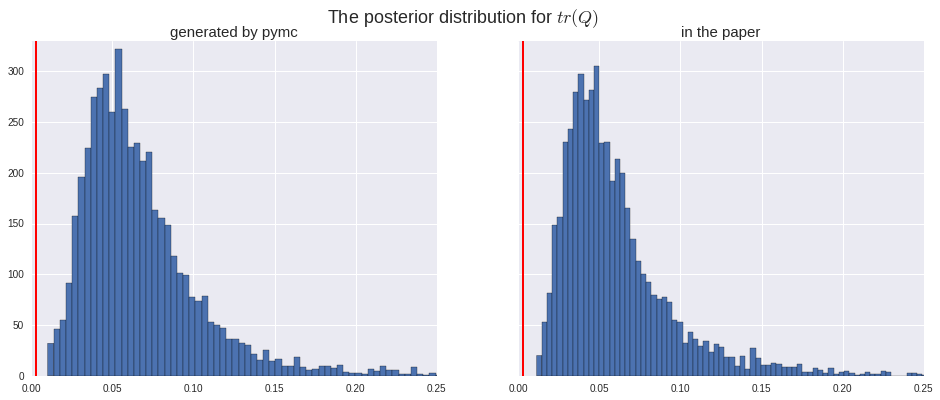

In [29]:
fig1, ax = plt.subplots(1, 2, figsize = (16, 6), sharex = True, sharey = True)
ax[0].axis([0, .25, 0, 330])
plt.suptitle(r'The posterior distribution for $tr(Q)$', fontsize = 18)

ax[0].hist([np.trace(inv(mcmc.trace('Q_inv')[:][i])) for i in range(sample_size)], bins = 140)
ax[0].vlines(np.trace(Q_bar/(1+KM)), 0, 330, color = 'r', lw = 2)
ax[0].set_title('generated by pymc', fontsize = 15)

ax[1].hist([np.trace(matlab_Q[:, :, i]) for i in range(matlab_sample_size)], bins = 93)
ax[1].vlines(np.trace(Q_bar/(1+KM)), 0, 330, color = 'r', lw = 2)
ax[1].set_title('in the paper', fontsize = 15)

plt.savefig('../figures/fig1.pdf')

### Figure 2

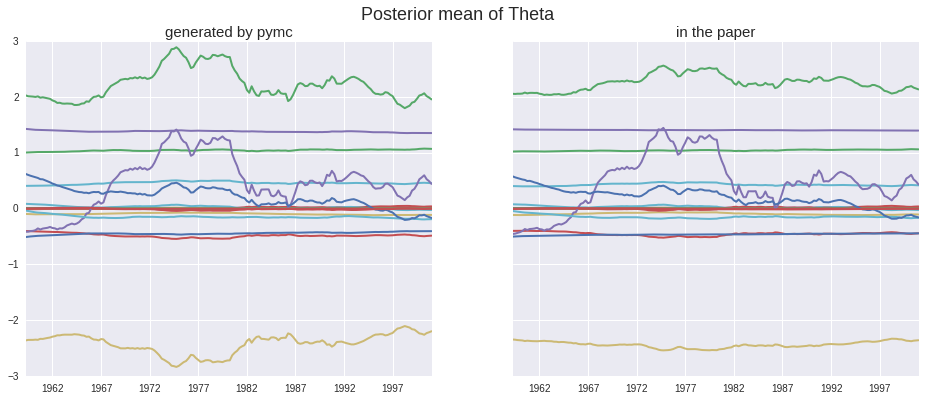

In [20]:
date_axis = np.asarray(pd.date_range('1959-01-01', '2000-12-31', freq = 'Q'))

post_mean_theta_matlab = np.mean(matlab_Theta, 2)
post_mean_theta = np.empty((KM, T))
for j in range(KM):
    post_mean_theta[j, :] = [np.mean(mcmc.trace('Theta_%d' % i)[:][:, j]) for i in np.arange(1, T + 1)]


fig2, ax = plt.subplots(1, 2, figsize = (16, 6), sharex = True, sharey = True)
plt.suptitle(r'Posterior mean of Theta', fontsize = 18)
ax[0].plot(date_axis, post_mean_theta.T, linewidth = 2)
ax[0].set_title('generated by pymc', fontsize = 15)
ax[1].plot(date_axis, post_mean_theta_matlab.T, linewidth = 2)
ax[1].set_title('in the paper', fontsize = 15)

plt.savefig('../figures/fig2.pdf')

### Figure 3

In [21]:
R_sample = np.empty((sample_size, T + 1, K, K))
R_sample_matlab = np.empty((matlab_sample_size, T + 1, K, K))

for i in range(sample_size):
    
    Binv = inv(B_tril(mcmc.trace('betas')[:][i, :]))
    Binv_matlab = inv(B_tril(matlab_Betas[:, i]))
    
    for tt in range(T + 1):
        H_matrix = np.diag(np.exp(mcmc.trace('lnh_%d' % tt)[:][i, :]))
        H_matrix_matlab = np.diag(matlab_H[tt, :, i])
        
        R = Binv  @ H_matrix @ Binv.T
        R_matlab = Binv_matlab  @ H_matrix_matlab @ Binv_matlab.T
        
        R_sample[i, tt, :, :] = R
        R_sample_matlab[i, tt, :, :] = R_matlab


R_mean = np.mean(R_sample, 0)
R_mean_matlab = np.mean(R_sample_matlab, 0)

nomint = np.sqrt(R_mean[:, 0, 0])
nomint_matlab = np.sqrt(R_mean_matlab[:, 0, 0])

unemp = np.sqrt(R_mean[:, 1, 1])
unemp_matlab = np.sqrt(R_mean_matlab[:, 1, 1])

inflation = np.sqrt(R_mean[:, 2, 2])
inflation_matlab = np.sqrt(R_mean_matlab[:, 2, 2])

corr_nu = R_mean[:, 0, 1]/(nomint * unemp)
corr_nu_matlab = R_mean_matlab[:, 0, 1]/(nomint_matlab * unemp_matlab)

corr_ni = R_mean[:, 0, 2]/(nomint * inflation)
corr_ni_matlab = R_mean_matlab[:, 0, 2]/(nomint_matlab * inflation_matlab)

corr_iu = R_mean[:, 1, 2]/(unemp * inflation)
corr_iu_matlab = R_mean_matlab[:, 1, 2]/(unemp_matlab * inflation_matlab)

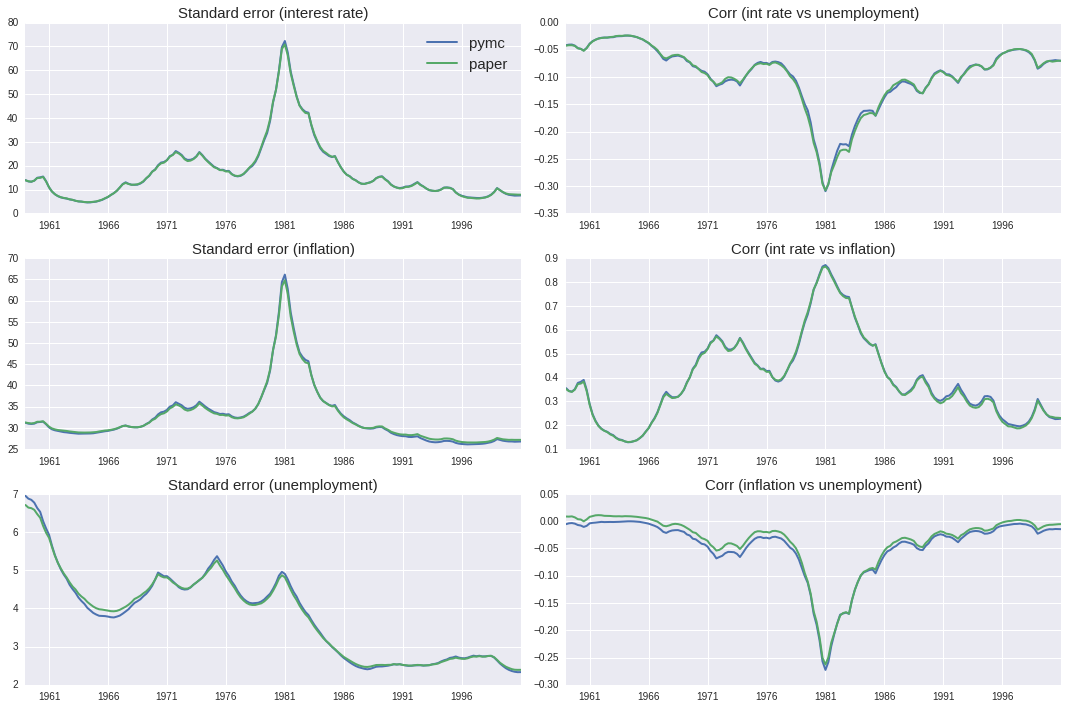

In [22]:
date_axis = np.asarray(pd.date_range('1958-12-01', '2000-12-31', freq = 'Q'))

fig3, ax = plt.subplots(3, 2, figsize = (15, 10))
ax[0, 0].plot(date_axis, 1e4*nomint, linewidth = 2, label = 'pymc')
ax[0, 0].plot(date_axis, 1e4*nomint_matlab, linewidth = 2, label = 'paper')
ax[0, 0].set_title(r'Standard error (interest rate)', fontsize = 15)
ax[0, 0].legend(loc = 'best', fontsize = 15)

ax[1, 0].plot(date_axis, 1e4*inflation, linewidth = 2)
ax[1, 0].plot(date_axis, 1e4*inflation_matlab, linewidth = 2)
ax[1, 0].set_title(r'Standard error (inflation)', fontsize = 15)

ax[2, 0].plot(date_axis, 1e4*unemp, linewidth = 2)
ax[2, 0].plot(date_axis, 1e4*unemp_matlab, linewidth = 2)
ax[2, 0].set_title(r'Standard error (unemployment)', fontsize = 15)

ax[0, 1].plot(date_axis, corr_nu, linewidth = 2)
ax[0, 1].plot(date_axis, corr_nu_matlab, linewidth = 2)
ax[0, 1].set_title(r'Corr (int rate vs unemployment)', fontsize = 15)

ax[1, 1].plot(date_axis, corr_ni, linewidth = 2)
ax[1, 1].plot(date_axis, corr_ni_matlab, linewidth = 2)
ax[1, 1].set_title(r'Corr (int rate vs inflation)', fontsize = 15)

ax[2, 1].plot(date_axis, corr_iu, linewidth = 2)
ax[2, 1].plot(date_axis, corr_iu_matlab, linewidth = 2)
ax[2, 1].set_title(r'Corr (inflation vs unemployment)', fontsize = 15)
plt.tight_layout()

plt.savefig('../figures/fig3.pdf')

### Figure 4

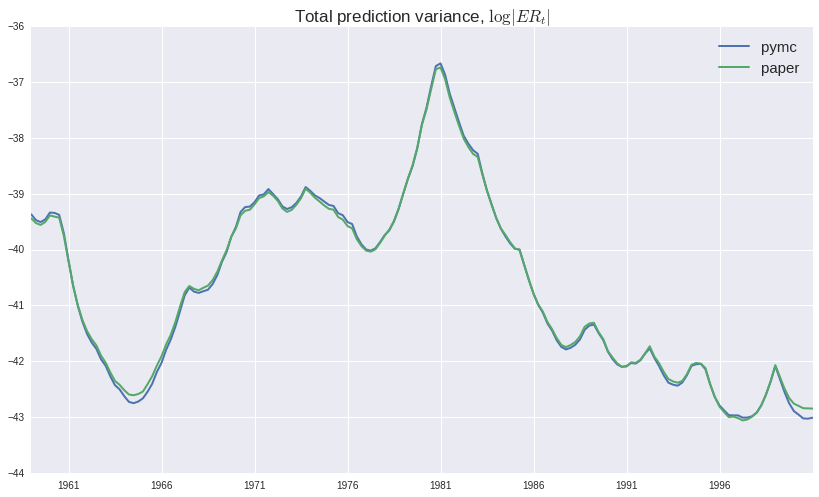

In [23]:
logdetR = np.empty((T + 1, 1))
logdetR_matlab = np.empty((T + 1, 1))

for tt in range(T + 1):
    logdetR[tt, 0] = np.log(np.linalg.det(R_mean[tt, :, :]))
    logdetR_matlab[tt, 0] = np.log(np.linalg.det(R_mean_matlab[tt, :, :]))

fig3, ax = plt.subplots(figsize = (14, 8))
ax.plot(date_axis, logdetR, linewidth = 2, label = 'pymc')
ax.plot(date_axis, logdetR_matlab, linewidth = 2, label = 'paper')
ax.set_title(r'Total prediction variance, $\log |E R_t|$', fontsize = 17)
ax.legend(loc = 'best', fontsize = 15)

plt.savefig('../figures/fig4.pdf')